## 02686 Exam Report

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


## 1.1 Prey predator

In [ ]:
# Prey predator function valuation
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1= a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1,dx2]

# Jacobian of prey predator valuation
def PreyPredator_Jac(t, x, a, b):
    x1, x2 = x
    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    x2_ = -b * (1 - x[0]) * x[1]
    return [[dx1x1, dx1x2], [dx2x1, dx2x2]]

# Prey predator function and jacobian
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x

    dx1= a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    return [dx1,dx2], [[dx1x1, dx1x2], [dx2x1, dx2x2]]

## 1.2 Van der Pol

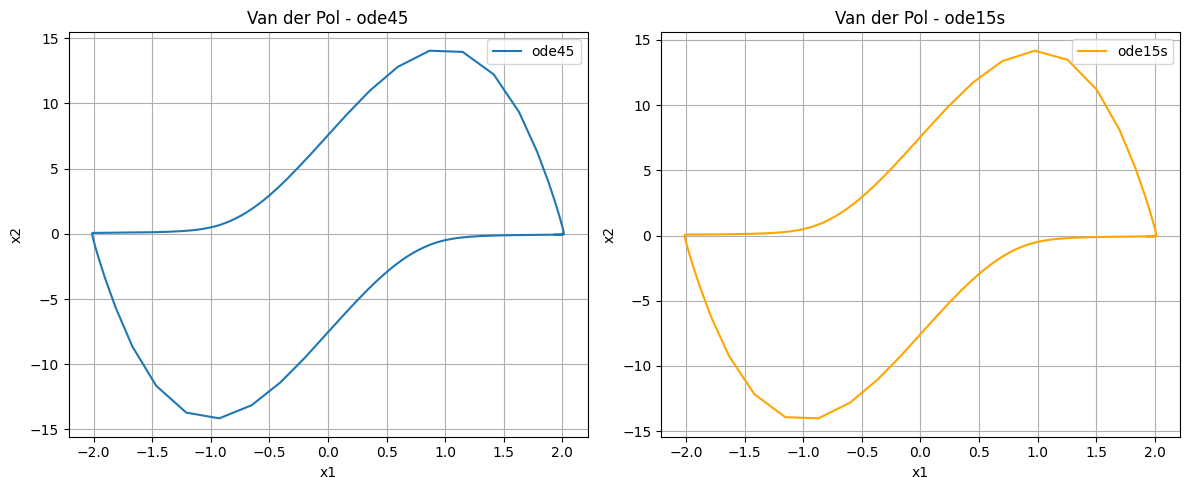

In [ ]:
def VanDerPol(t,x,mu):

    x1_ = x[1]

    x2_ = mu*(1-x[0]**2)*x[1]-x[0]

    return [x1_,x2_]

def VanDerPol_Jac(t, x, mu):
    x1, x2 = x
    return [
        [0, 1],
        [-2 * mu * x1 * x2 - 1, mu * (1 - x1**2)]
    ]

mu = 10
x0 = [2.0, 0.0]
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)  

sol_ode45 = solve_ivp(VanDerPol, t_span, x0, args=(mu,), t_eval=t_eval, method='RK45')

sol_ode15s = solve_ivp(VanDerPol, t_span, x0, args=(mu,), t_eval=t_eval, method='BDF',jac = VanDerPol_Jac)


"""
plt.plot(solution.t, solution.y[0], label='x1 (Position)')
plt.plot(solution.t, solution.y[1], label='x2 (Velocity)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Van der Pol Oscillator')
plt.grid()
plt.show()

plt.figure()
plt.plot(solution.y[0], solution.y[1], label='Ode45')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Van der Pol Oscillator - Time Evolution')
plt.grid()
plt.show()
"""
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# Plot RK45 (ode45)
axs[0].plot(sol_ode45.y[0], sol_ode45.y[1], label='ode45')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_title('Van der Pol - ode45')
axs[0].legend()
axs[0].grid()

# Plot BDF (ode15s)
axs[1].plot(sol_ode15s.y[0], sol_ode15s.y[1], label='ode15s', color='orange')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_title('Van der Pol - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


## 1.3 Chemical Reaction in a Continuous Stirred Tank Reactor (CSTR)

CSTR 3 state

In [ ]:
def CSTR(t, C, C0):
    # Given constants 
    deltaHr = -560              # kJ/mol
    rho = 1.0                   # kg/L
    cp = 4.186                  # kJ/(kg*K)
    E_adv_R = 8500              # E_a div med E
    k0 = np.exp(24.6)           # L/(mol*s)
    A = 0.1                     # m^2
    V = 0.105                   # L (according to a Wahlgreen (2020))
    
    CA, CB, T = C


    # Calculating constants
    k = k0 * np.exp(-E_adv_R/T)
    beta = - deltaHr/(rho*cp)
    v = np.array([-1, -2, beta])
    F = 250#v * A
    r=k*CA*CB
    
    # Reaction rate
    R = v.T*r #v transposed

    
    # Calculating the change in concentration
    system = (C0-C) * F/V + R
    dCA, dCB, dT = system

    return [dCA, dCB, dT]

def CSTR_Jac(t, C, C0):
    # Given constants 
    deltaHr = -560              # kJ/mol
    rho = 1.0                   # kg/L
    cp = 4.186                  # kJ/(kg*K)
    E_adv_R = 8500              # E_a div med R
    k0 = np.exp(24.6)           # L/(mol*s)
    A = 0.1                     # m^2
    V = 0.105                   # L (according to a Wahlgreen (2020))
    
    CA, CB, T = C
    # Calculating constants
    k = k0 * np.exp(-E_adv_R/T)
    beta = - deltaHr/(rho*cp)
    v = np.array([-1, -2, beta])

    #F = v * A
    F = 250

    r=k*CA*CB   

    Jac = np.array([
        [-F/V - k*CB,          -k*CA,         ((1/T**(2))*(E_adv_R))*(-r)],
        [-2*k*CB,              -F/V - 2*k*CA, ((1/T**(2))*(E_adv_R))*(-2*r)],
        [beta*k*CB,            beta*k*CA,     ((1/T**(2))*(E_adv_R))*(beta*r)+(F/V)]
    ])

    return Jac





Cin = np.array([1.6/2, 2.4/2, 600])  # inlet concentration
C0 = np.array([0.1, 0.1, 600])       # initial reactor state


t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)  

sol_ode45 = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='RK45')
sol_ode15s = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='BDF', jac=CSTR_Jac)

print(CSTR_Jac(1,C0,Cin))



fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot RK45 (ode45)
axs[0].plot(t_eval, sol_ode45.y[0], label='C_A')
axs[0].plot(t_eval, sol_ode45.y[1], label='C_B')
#axs[0].plot(t_eval, sol_ode45.y[2], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Concentration and temperature')
axs[0].set_title('CSTR - ode45')
axs[0].legend()
axs[0].grid()


# Plot BDF (ode15s)
axs[1].plot(t_eval, sol_ode15s.y[0], label='C_A')
axs[1].plot(t_eval, sol_ode15s.y[1], label='C_B')
#axs[1].plot(t_eval, sol_ode15s.y[2], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Concentration and temperature')
axs[1].set_title('CSTR - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

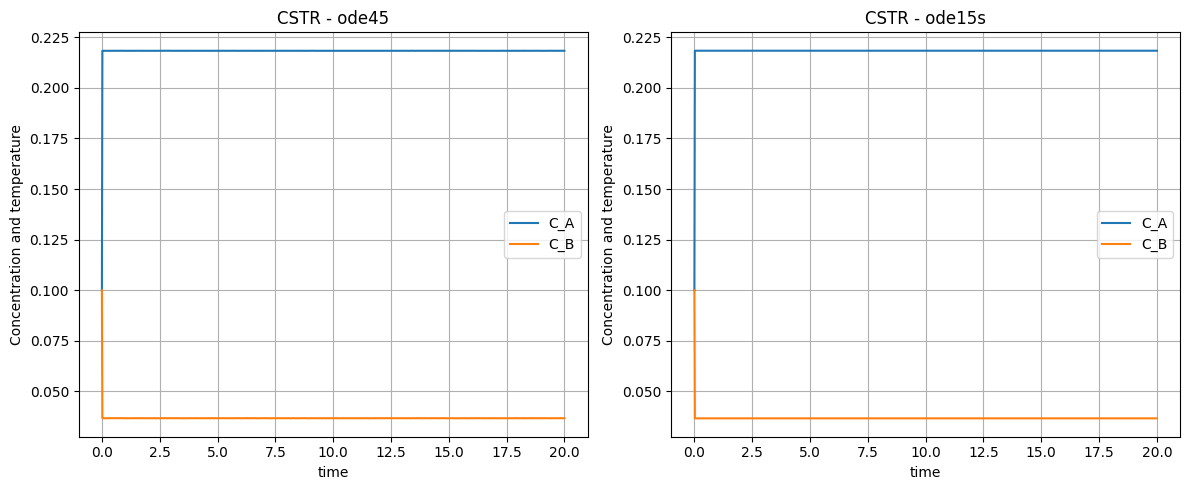

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot RK45 (ode45)
axs[0].plot(t_eval, sol_ode45.y[0], label='C_A')
axs[0].plot(t_eval, sol_ode45.y[1], label='C_B')
#axs[0].plot(t_eval, sol_ode45.y[2], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Concentration and temperature')
axs[0].set_title('CSTR - ode45')
axs[0].legend()
axs[0].grid()


# Plot BDF (ode15s)
axs[1].plot(t_eval, sol_ode15s.y[0], label='C_A')
axs[1].plot(t_eval, sol_ode15s.y[1], label='C_B')
#axs[1].plot(t_eval, sol_ode15s.y[2], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Concentration and temperature')
axs[1].set_title('CSTR - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
def CSTR(t, C, Cin):
    # Constants
    deltaHr = -560               # kJ/mol
    rho = 1.0                    # kg/L
    cp = 4.186                   # kJ/(kg*K)
    Ea_over_R = 8500             # K
    k0 = np.exp(24.6)            # L/(mol*s)
    V = 0.105                    # L (from Wahlgreen 2020)
    F = 0.1                      # L/s  (assumed constant flowrate, realistic)

    # State variables
    CA, CB, T = C

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R/T)

    # Reaction model
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])  # stoichiometric vector

    # Reaction term
    R = v * r

    # CSTR dynamics
    dCdt = (Cin - C) * F / V + R

    return dCdt.tolist()

def CSTR_Jac(t, C, Cin):
    # Constants
    deltaHr = -560               # kJ/mol
    rho = 1.0                    # kg/L
    cp = 4.186                   # kJ/(kg*K)
    Ea_over_R = 8500             # K
    k0 = np.exp(24.6)            # L/(mol*s)
    V = 0.105                    # L
    F = 0.1                      # L/s

    # State variables
    CA, CB, T = C

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R/T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)

    # Stoichiometry
    v = np.array([-1, -2, beta])

    # Partial derivatives
    dk_dT = (Ea_over_R / T**2) * k

    # Build the Jacobian matrix
    Jac = np.array([
        [-F/V - k*CB,      -k*CA,       -(dk_dT * CA * CB)],
        [-F/V - 2*k*CB,    -F/V - 2*k*CA, -(2 * dk_dT * CA * CB)],
        [beta*k*CB,        beta*k*CA,    beta*(-dk_dT*CA*CB) + (-F/V)]
    ])

    return Jac


In [ ]:
C0 = np.array([1.6/2, 2.4/2, 600])  # Initial condition
Cin = np.array([1.6/2, 2.4/2,600]) # Assume inlet concentration = initial for now

t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

sol_ode45 = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='RK45')
sol_ode15s = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='BDF', jac=CSTR_Jac)


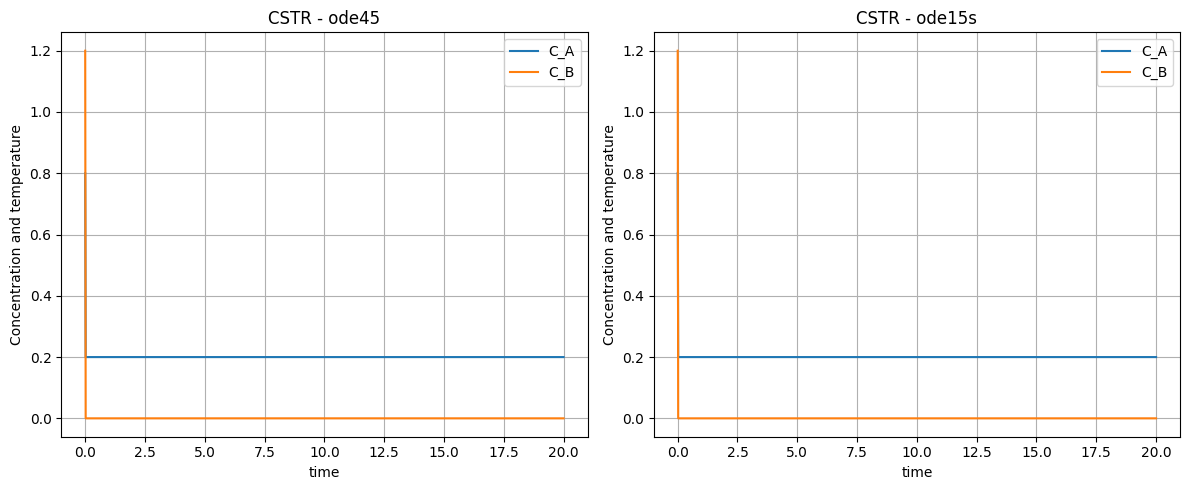

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot RK45 (ode45)
axs[0].plot(t_eval, sol_ode45.y[0], label='C_A')
axs[0].plot(t_eval, sol_ode45.y[1], label='C_B')
#axs[0].plot(t_eval, sol_ode45.y[2], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Concentration and temperature')
axs[0].set_title('CSTR - ode45')
axs[0].legend()
axs[0].grid()


# Plot BDF (ode15s)
axs[1].plot(t_eval, sol_ode15s.y[0], label='C_A')
axs[1].plot(t_eval, sol_ode15s.y[1], label='C_B')
#axs[1].plot(t_eval, sol_ode15s.y[2], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Concentration and temperature')
axs[1].set_title('CSTR - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

CSTR 1-state

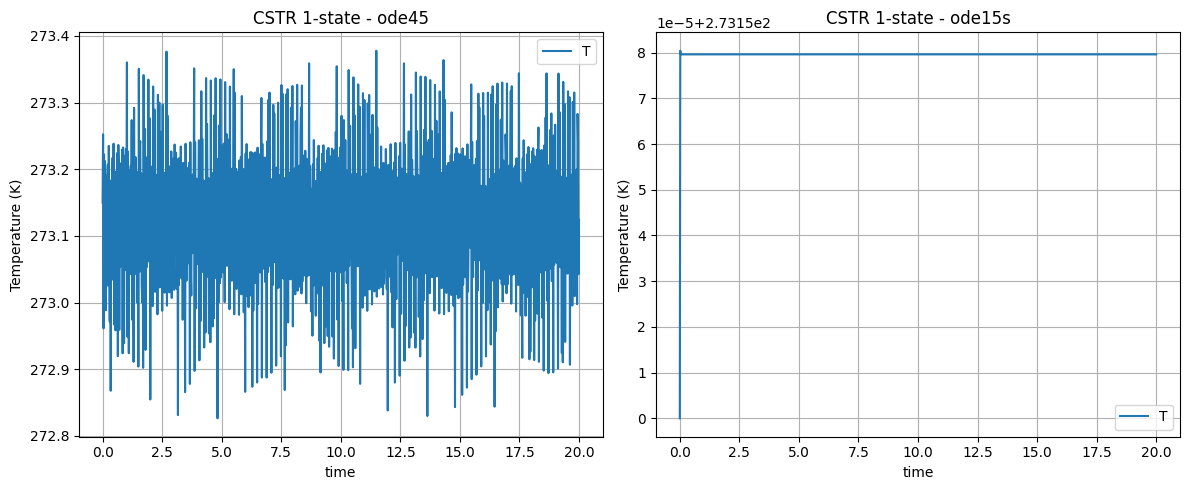

In [ ]:
def CSTR_1state(t, T, Tin):

    T = T[0]
    # Constants from Wahlgreen et al. (2020)
    deltaHr = -560               # kJ/mol
    rho = 1.0                    # kg/L
    cp = 4.186                   # kJ/(kg*K)
    Ea_over_R = 8500             # K
    k0 = np.exp(24.6)            # L/(mol*s)
    V = 0.105                    # L
    F = 250                      # L/s

    CA_in = 1.6/2                # mol/L
    CB_in = 2.4/2                # mol/L

    beta = -deltaHr / (rho * cp)


    CA = CA_in + 1/beta * (T0-T)
    CB = CB_in + 2/beta * (T0-T)

    k = k0 * np.exp(-Ea_over_R/T)

    r = k * CA * CB


    dTdt = (Tin - T) * F/V + beta * r

    return [dTdt]



def CSTR_1state_Jac(t, T, Tin):

    T = T[0]
    
    
    deltaHr = -560               
    rho = 1.0                   
    cp = 4.186                  
    Ea_over_R = 8500            
    k0 = np.exp(24.6)           
    V = 0.105                   
    F = 250                     
    # Fixed concentrations

    CA_in = 1.6/2
    CB_in = 2.4/2
    beta = -deltaHr / (rho * cp)

    CA = CA_in + 1/beta * (T0-T)
    CB = CB_in + 2/beta * (T0-T)

    k = k0 * np.exp(-Ea_over_R/T)
    r = k * CA * CB

    # k0 * np.exp(-Ea_over_R/T)*(CA_in + 1/beta * (T0-T))*(CB_in + 2/beta * (T0-T))

    #

    #from chatten 
    
    k = k0 * np.exp(-Ea_over_R / T)
    CA = CA_in + (1/beta)*(T0 - T)
    CB = CB_in + (2/beta)*(T0 - T)

    # Derivatives
    dk_dT = (Ea_over_R / T**2) * k
    dCA_dT = -1/beta
    dCB_dT = -2/beta

    # Full derivative using product rule
    dr_dT = dk_dT * CA * CB + k * dCA_dT * CB + k * CA * dCB_dT
    #end here


    #dk_dT = (Ea_over_R / T**2) * k

    #dr_dT = dk_dT * CA * CB

    Jac = np.array([
        [-F/V + beta * dr_dT]
    ])

    return Jac

# -------------------------------------------------------------------

# Set initial and inlet conditions
T0 = 273.15       # initial reactor temperature
Tin = 273.15      # inlet feed temperature

t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 1000)
 
# Solve the ODE
sol_ode45 = solve_ivp(CSTR_1state, t_span, [T0], args=(Tin,), t_eval=t_eval, method='RK45')
sol_ode15s = solve_ivp(CSTR_1state, t_span, [T0], args=(Tin,), t_eval=t_eval, method='BDF', jac=CSTR_1state_Jac)

# -------------------------------------------------------------------

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot ode45
axs[0].plot(t_eval, sol_ode45.y[0], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Temperature (K)')
axs[0].set_title('CSTR 1-state - ode45')
axs[0].legend()
axs[0].grid()

# Plot ode15s
axs[1].plot(t_eval, sol_ode15s.y[0], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Temperature (K)')
axs[1].set_title('CSTR 1-state - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()




## PFR 3-state

In [ ]:
import numpy as np


def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    DA = p['DA']
    DB = p['DB']
    DT = p['DT']
    k = p['k']


    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
    
    deltaHr = -560               
    rho = 1.0                   
    cp = 4.186                  
    Ea_over_R = 8500            
    k0 = np.exp(24.6)           
    V = 0.105                   
    F = 250      
    beta = -deltaHr / (rho * cp)

    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    
    # Convection at finite volume interfaces
    NconvA = np.zeros(n+1)
    NconvA[0] = v * CAin
    NconvA[1:n+1] = v * CA[0:n]
    
    NconvB = np.zeros(n+1)
    NconvB[0] = v * CBin
    NconvB[1:n+1] = v * CB[0:n]

    NconvT = np.zeros(n+1)
    NconvT[0] = v * Tin
    NconvT[1:n+1] = v * T[0:n]
    

    # Diffusion at finite volume interfaces
    JA = np.zeros(n+1)
    JA[1:n] = (-DA/dz) * (CA[1:n] - CA[0:n-1])

    JB = np.zeros(n+1)
    JB[1:n] = (-DB/dz) * (CB[1:n] - CB[0:n-1])

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT
    
    # Reaction and production rates in finite volumes
    r = k * CA * CB
    RA = -r
    RB = -2*r
    RT = beta*r
    
    # Differential Equations (mass balances at finite volumes)
    CAdot = (NA[1:n+1] - NA[0:n])/(-dz) + RA
    CBdot = (NA[1:n+1] - NB[0:n])/(-dz) + RB
    Tdot = (NA[1:n+1] - NT[0:n])/(-dz) + RT
    
    return np.vstack([CAdot, CBdot, Tdot]).flatten()


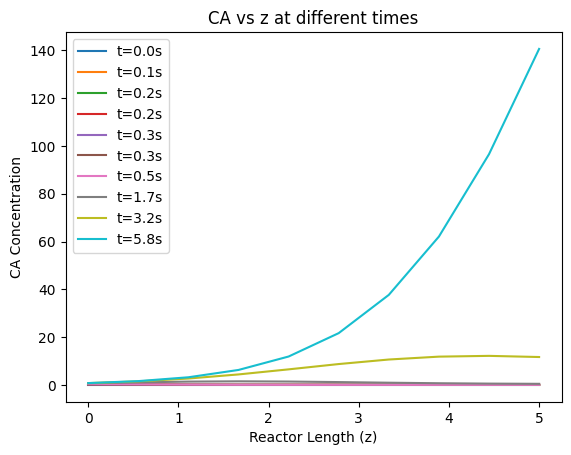

In [76]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Parameters
Nz = 10
L = 10
v = 3
k = 4
DA = 0.1
DB = 0.1
DT = 0.1
uk = 3
x0 = np.full(Nz, 0.1)

# Derived Parameters
deltaz = L / Nz
delta = v / deltaz
beta = (v + DA / deltaz) / deltaz
gamma = DA / deltaz**2
alpha = beta + gamma + k
alphathilde = beta + k

# Pack parameters into a dictionary
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'k': k,
    'DA': DA,
    'DB': DB,
    'DT': DT
}

# Initial conditions
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

Cin = (1.6, 2.4, 350)
t_span = (0, 10)

sol = solve_ivp(lambda t, C: PFR_3state(t, C, Cin, p),
                t_span, C0, method='BDF', rtol=1e-6, atol=1e-6)

# Plot CA at different times
Z = np.linspace(0, 5, Nz)
for i in range(0, len(sol.t), max(1, len(sol.t)//10)):
    CA_i = sol.y[0:Nz, i]
    plt.plot(Z, CA_i, label=f't={sol.t[i]:.1f}s')
    

plt.xlabel('Reactor Length (z)')
plt.ylabel('CA Concentration')
plt.legend()
plt.title('CA vs z at different times')
plt.show()




In [55]:
sol.t[100]

np.float64(0.10099941038806934)

In [ ]:
val=np.float64(sol.t[-1])

print(val)

10.0


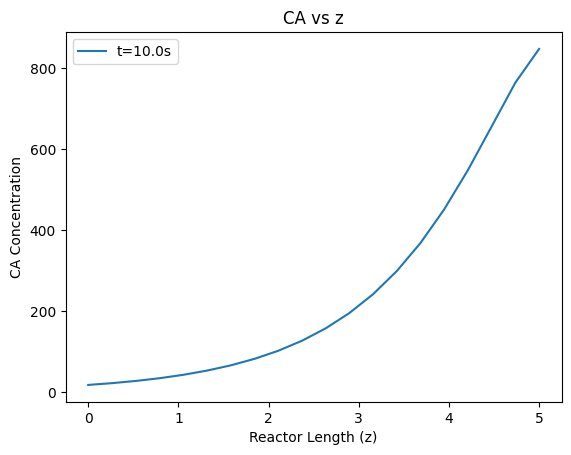

In [70]:
for idx, i in enumerate(sol.t):
    plt.clf()
    # Extract CA concentration at each time step
    CA_i = sol.y[0:Nz, idx]
    
    # Plot the data for the current time point
    plt.plot(Z, CA_i, label=f't={i}s')
    
    # Add labels and legend
    plt.xlabel('Reactor Length (z)')
    plt.ylabel('CA Concentration')
    plt.legend()
    plt.title('CA vs z')
    plt.draw()
    plt.pause(0.1)  # Pause to update the plot window

plt.show()


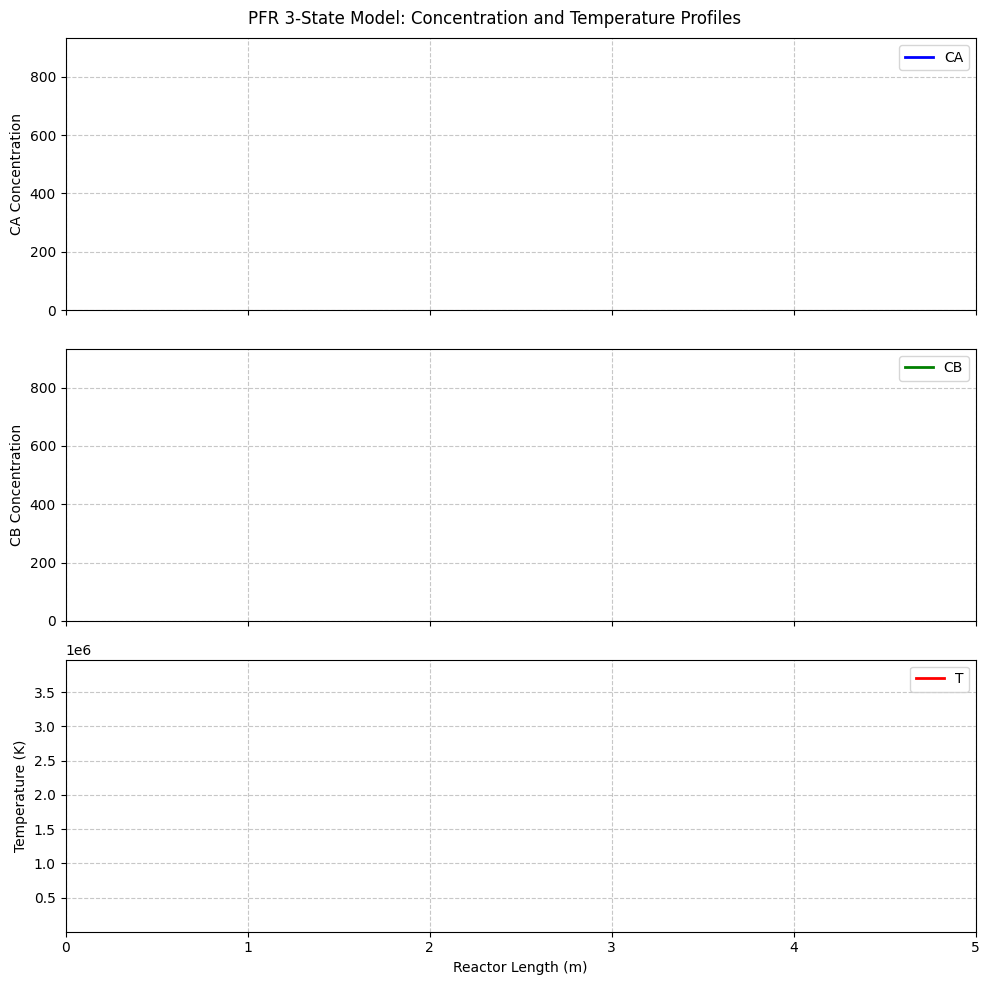

In [25]:
# Spatial domain
Z = np.linspace(0, L, Nz)
n_frames = sol.y.shape[1]  # number of time steps

# Extract time series data
CA_time = sol.y[0:Nz, :]
CB_time = sol.y[Nz:2*Nz, :]
T_time = sol.y[2*Nz:3*Nz, :]

# Setup figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
lines = []
labels = ['CA', 'CB', 'T']
colors = ['blue', 'green', 'red']
y_data = [CA_time, CB_time, T_time]

# Setup each subplot
for i, ax in enumerate(axs):
    line, = ax.plot([], [], lw=2, color=colors[i], label=labels[i])
    ax.set_xlim(0, L)
    if i < 2:  # For concentration plots
        ax.set_ylim(0, max(np.max(CA_time), np.max(CB_time)) * 1.1)
        ax.set_ylabel(f'{labels[i]} Concentration')
    else:  # For temperature plot
        ax.set_ylim(min(np.min(T_time) * 0.95, 340), np.max(T_time) * 1.05)
        ax.set_ylabel('Temperature (K)')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.7)
    lines.append(line)

axs[-1].set_xlabel('Reactor Length (m)')
fig.suptitle('PFR 3-State Model: Concentration and Temperature Profiles')

# Text label for time
time_text = axs[0].text(0.75, 0.85, '', transform=axs[0].transAxes)

# Initialization function
def init():
    for line in lines:
        line.set_data([], [])
    time_text.set_text('')
    return lines + [time_text]

# Update function
def update(frame):
    for i, line in enumerate(lines):
        y = y_data[i][:, frame]
        line.set_data(Z, y)
    time_text.set_text(f't = {sol.t[frame]:.2f}s')
    return lines + [time_text]

# Create animation - use a smaller subset of frames for smoother animation
step = max(1, n_frames // 100)  # Use at most 100 frames for the animation
selected_frames = range(0, n_frames, step)

ani = FuncAnimation(fig, update, frames=selected_frames,
                    init_func=init, blit=True, interval=100)

plt.tight_layout()
plt.show()

In [24]:
print("sol.y shape:", sol.y.shape)
print("Max CA:", np.max(sol.y[0:Nz, :]))
print("Max CB:", np.max(sol.y[Nz:2*Nz, :]))
print("Max T:", np.max(sol.y[2*Nz:3*Nz, :]))
print("Any NaNs in sol.y?", np.isnan(sol.y).any())


sol.y shape: (60, 206)
Max CA: 848.2651534355812
Max CB: 0.39809163433870587
Max T: 3787909.7566092825
Any NaNs in sol.y? False


# 2

plots for experimenting with stability

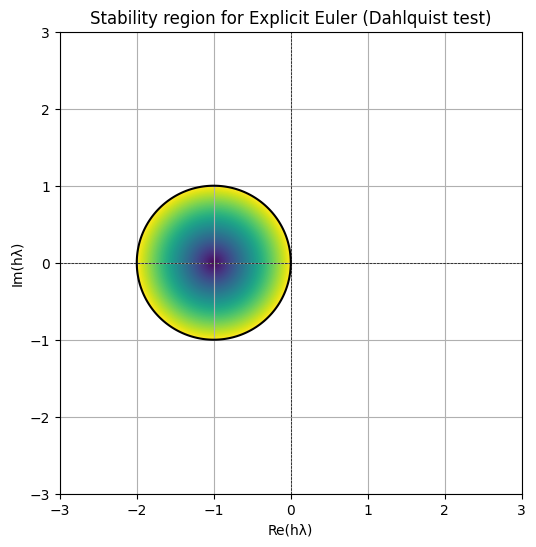

In [ ]:
# Create a grid in the complex plane
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Compute the Euler stability function
stability_function = 1 + Z

# Compute magnitude
stability_region = np.abs(stability_function)

# Plot
fig, ax = plt.subplots(figsize=(8,6))
#contour = ax.contourf(X, Y, stability_region <= 1, levels=[-1,-0.5,0,0.5,1])
max_val = np.max(stability_region)
levels = np.linspace(0, 1, 300)
contour = ax.contourf(X, Y, stability_region, levels=levels, cmap='viridis')
ax.contour(X, Y, stability_region, levels=[1], colors='black')  # Boundary line

ax.set_xlabel('Re(hλ)')
ax.set_ylabel('Im(hλ)')
ax.set_title('Stability region for Explicit Euler (Dahlquist test)')
ax.grid(True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_aspect('equal', 'box')

plt.show()


Steady-state: x* = 4.0, y* = 2.75
Eigenvalues: [0.+0.66332496j 0.-0.66332496j]


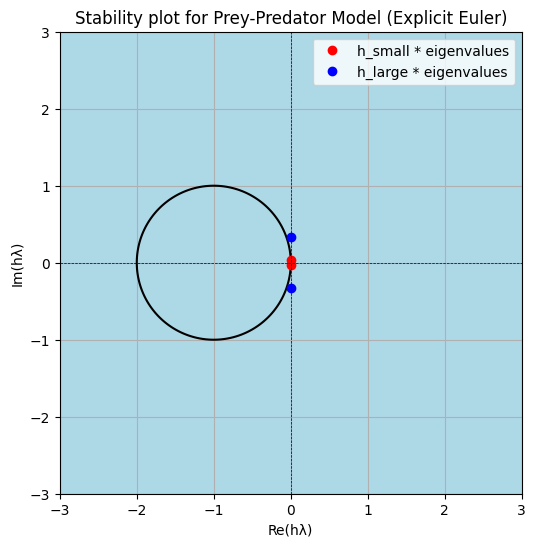

In [ ]:
# Model parameters
alpha = 1.1
beta = 0.4
delta = 0.1
gamma = 0.4

# Step size
h_small = 0.05
h_large = 0.5

# Steady-state solution (solve: dx/dt = dy/dt = 0)
x_star = gamma / delta
y_star = alpha / beta

print(f"Steady-state: x* = {x_star}, y* = {y_star}")

# Jacobian at steady-state
J = np.array([
    [alpha - beta * y_star,   -beta * x_star],
    [delta * y_star,          delta * x_star - gamma]
])

# Compute eigenvalues
eigvals = np.linalg.eigvals(J)

print(f"Eigenvalues: {eigvals}")


# -------- Stability plot for explicit Euler --------

# Create complex plane grid
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j*Y

# Stability function for explicit Euler
stability_function = 1 + Z
stability_region = np.abs(stability_function)

# Plot stability region
fig, ax = plt.subplots(figsize=(8,6))
ax.contourf(X, Y, stability_region <= 1, levels=1, colors=["lightblue"])
ax.contour(X, Y, stability_region, levels=[1], colors='black')

# Plot scaled eigenvalues
ax.plot(np.real(h_small * eigvals), np.imag(h_small * eigvals), 'ro', label='h_small * eigenvalues')
ax.plot(np.real(h_large * eigvals), np.imag(h_large * eigvals), 'bo', label='h_large * eigenvalues')


# Decorations
ax.set_xlabel('Re(hλ)')
ax.set_ylabel('Im(hλ)')
ax.set_title('Stability plot for Prey-Predator Model (Explicit Euler)')
ax.grid(True)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_aspect('equal', 'box')
ax.legend()

plt.show()


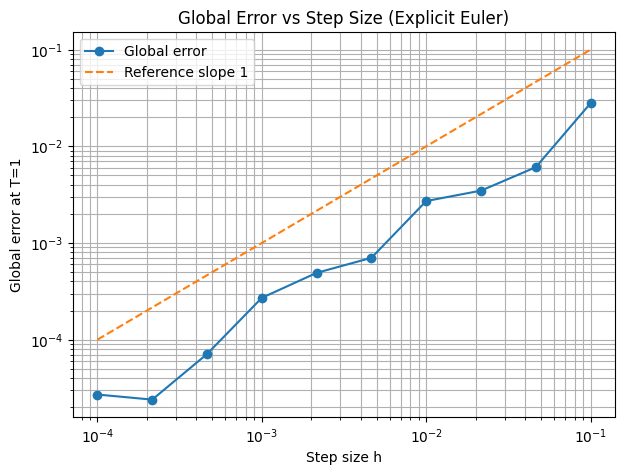

In [ ]:
# Define a simple ODE: dx/dt = -2x
def f(t, x):
    return -2*x

# Analytical solution
def true_solution(t):
    return np.exp(-2*t)

# Explicit Euler method
def euler_step(f, t0, x0, h, N):
    x = x0
    t = t0
    for _ in range(N):
        x = x + h * f(t, x)
        t = t + h
    return x

# Setup
t0 = 0
Tfinal = 1
x0 = 1

# Test different step sizes
h_values = np.logspace(-4, -1, 10)  # from 1e-4 to 1e-1
errors = []

for h in h_values:
    N = int((Tfinal - t0)/h)
    x_num = euler_step(f, t0, x0, h, N)
    x_true = true_solution(Tfinal)
    error = np.abs(x_num - x_true)
    errors.append(error)

# Plot error vs h
plt.figure(figsize=(7,5))
plt.loglog(h_values, errors, 'o-', label='Global error')
plt.loglog(h_values, h_values, '--', label='Reference slope 1')  # Line of slope 1
plt.xlabel('Step size h')
plt.ylabel('Global error at T=1')
plt.title('Global Error vs Step Size (Explicit Euler)')
plt.grid(True, which='both')
plt.legend()
plt.show()


## Explicit solver with fixed and adaptive step

In [ ]:
from ExplicitEulerFixedStep import ExplicitEulerFixedStep

def VanDerPol(t, x, mu):
    x1_ = x[1]
    x2_ = mu * (1 - x[0]**2) * x[1] - x[0]
    return [x1_, x2_]

mu = 10
x0 = np.array([2.0, 0.0])
t_span = (0, 20)
t0 = t_span[0]
TN = t_span[1]
N = 10000


# Solve the ODE
T, X = ExplicitEulerFixedStep(VanDerPol, t0, TN, N, x0, mu)


NameError: name 'np' is not defined

In [ ]:
def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    # Error controller parameters
    epstol = 0.8  # Safety factor
    facmin = 0.1  # Maximum decrease factor
    facmax = 5.0  # Maximum increase factor

    # Integration interval
    t0, tf = tspan

    # Initial conditions
    t = t0
    h = h0
    x = np.array(x0, dtype=float)  # Ensure x is a NumPy array

    # Counters
    nfun = 0
    naccept = 0
    nreject = 0

    # Output storage
    T = np.array([t])  # Ensure T is a 1D NumPy array
    X = np.array([x])  # Ensure X is a 2D NumPy array

    # Algorithm
    while t < tf:
        if t + h > tf:
            h = tf - t

        f = np.array(fun(t, x, *args), dtype=float)  # Ensure f is a NumPy array

        AcceptStep = False

        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h

            tm = t + hm
            xm = x + hm * f

            fm = np.array(fun(tm, xm, *args), dtype=float)  # Ensure fm is a NumPy array
            nfun += 3
            x1hat = xm + hm * fm

            # Error estimation
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)  # Fix element-wise max
            r = np.max(np.abs(e) / denom)  # Compute max ratio

            AcceptStep = r <= epstol

            if AcceptStep:
                t = t + h
                x = x1hat

                naccept += 1
                T = np.append(T, t)  # Append t to the 1D array
                X = np.vstack([X, x1hat.reshape(1, -1)])  # Ensure correct shape
            else:
                nreject += 1

            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    return T, X



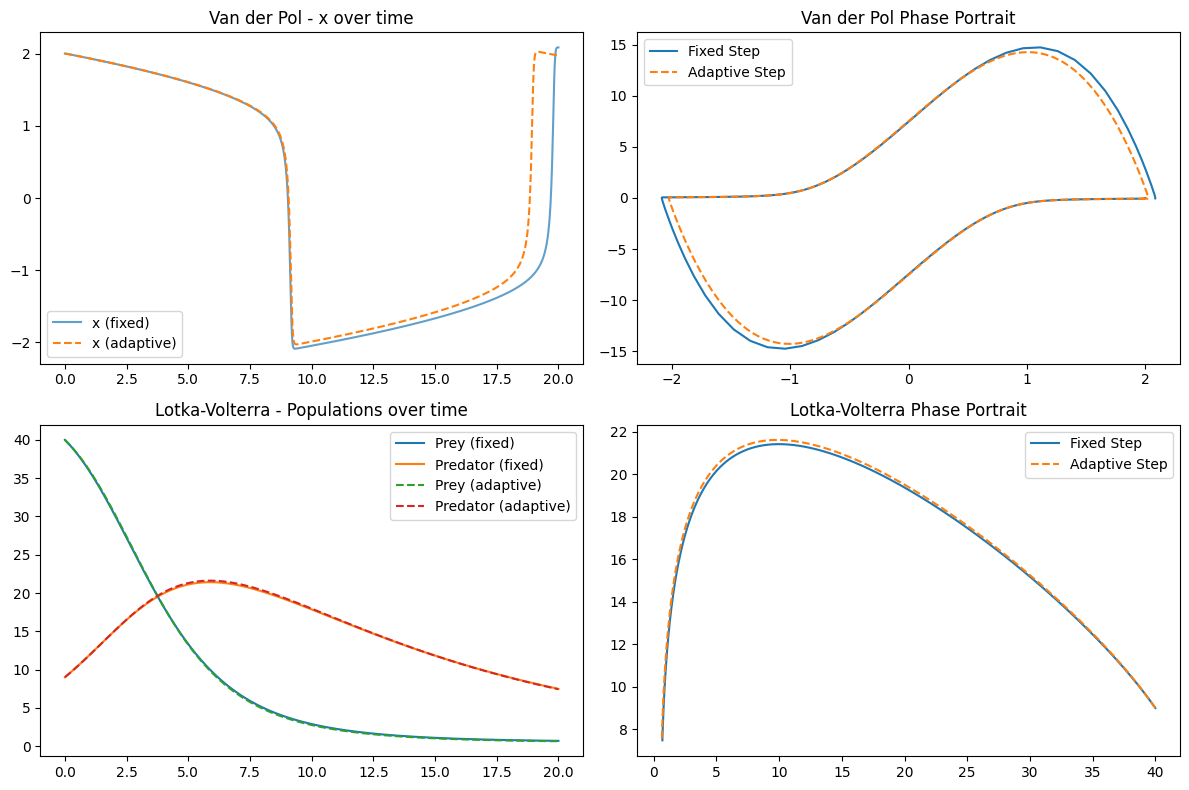

In [ ]:
##now running both with code for chatgbt


import numpy as np
import matplotlib.pyplot as plt


def ExplicitEulerFixedStep(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)

    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)

    T[0] = t0
    X[0, :] = x0

    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt

    return T, X


def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0

    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)

    nfun = 0
    naccept = 0
    nreject = 0

    T = np.array([t])
    X = np.array([x])

    while t < tf:
        if t + h > tf:
            h = tf - t

        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False

        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            nfun += 3

            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol

            if AcceptStep:
                t = t + h
                x = x1hat
                naccept += 1
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
            else:
                nreject += 1

            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h

    return T, X


def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]


def LotkaVolterra(t, x, alpha, beta, delta, gamma):
    prey, predator = x
    dxdt = alpha * prey - beta * prey * predator
    dydt = delta * prey * predator - gamma * predator
    return [dxdt, dydt]


# Parameters and initial conditions
mu = 10
x0_vdp = [2.0, 0.0]
tspan = (0, 20)
N = 2000 #har sat den extra lidt lavere

# Van der Pol - Fixed Step
T1, X1 = ExplicitEulerFixedStep(VanDerPol, tspan[0], tspan[1], N, x0_vdp, mu)
# Van der Pol - Adaptive Step
T2, X2 = ExplicitEulerAdaptiveStep(VanDerPol, tspan, x0_vdp, 0.01, 1e-6, 1e-3, mu)

# Prey-Predator model
x0_lv = [40, 9]
alpha, beta, delta, gamma = 0.1, 0.02, 0.01, 0.1

# Lotka-Volterra - Fixed Step
T3, X3 = ExplicitEulerFixedStep(LotkaVolterra, tspan[0], tspan[1], N, x0_lv, alpha, beta, delta, gamma)
# Lotka-Volterra - Adaptive Step
T4, X4 = ExplicitEulerAdaptiveStep(LotkaVolterra, tspan, x0_lv, 0.1, 1e-6, 1e-3, alpha, beta, delta, gamma)

# Plotting
plt.figure(figsize=(12, 8))

# Van der Pol
plt.subplot(2, 2, 1)
plt.plot(T1, X1[:, 0], label='x (fixed)', alpha=0.7)
plt.plot(T2, X2[:, 0], label='x (adaptive)', linestyle='dashed')
plt.title("Van der Pol - x over time")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(X1[:, 0], X1[:, 1], label='Fixed Step')
plt.plot(X2[:, 0], X2[:, 1], label='Adaptive Step', linestyle='dashed')
plt.title("Van der Pol Phase Portrait")
plt.legend()

# Lotka-Volterra
plt.subplot(2, 2, 3)
plt.plot(T3, X3[:, 0], label='Prey (fixed)')
plt.plot(T3, X3[:, 1], label='Predator (fixed)')
plt.plot(T4, X4[:, 0], '--', label='Prey (adaptive)')
plt.plot(T4, X4[:, 1], '--', label='Predator (adaptive)')
plt.title("Lotka-Volterra - Populations over time")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(X3[:, 0], X3[:, 1], label='Fixed Step')
plt.plot(X4[:, 0], X4[:, 1], label='Adaptive Step', linestyle='dashed')
plt.title("Lotka-Volterra Phase Portrait")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

def VanDerPol_Jac(t, x, mu):
    return np.array([
        [0, 1],
        [-1 - 2 * mu * x[0] * x[1], mu * (1 - x[0] ** 2)]
    ])



# Jacobian of prey predator valuation
def PreyPredator_Jac(t, x, a, b):
    x1, x2 = x
    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    x2_ = -b * (1 - x[0]) * x[1]
    return [[dx1x1, dx1x2], [dx2x1, dx2x2]]

# Prey predator function and jacobian
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x

    dx1= a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2) 
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    return [dx1,dx2], [[dx1x1, dx1x2], [dx2x1, dx2x2]]

from scipy.integrate import solve_ivp


# New Prey-Predator system parameters
a, b = 1.0, 1.0
x0_pp = [3.0, 2.0]
N_pp = 100


# Time points to evaluate the benchmark at
t_eval = np.linspace(tspan[0], tspan[1], 1000)

# BDF Solver (stiff solver) as benchmark
sol_ode15s = solve_ivp(
    VanDerPol, t_span, x0_vdp, args=(mu,), method='BDF',
    jac=VanDerPol_Jac, t_eval=t_eval, rtol=1e-9, atol=1e-12
)

# Fixed Step
T3, X3 = explicit_euler_fixed_step_size(PreyPredator, tspan[0], tspan[1], N_pp, x0_pp, a, b)

# Adaptive Step
T4, X4 = ExplicitEulerAdaptiveStep(PreyPredator, tspan, x0_pp, 0.1, 1e-6, 1e-3, a, b)

sol_ode15s = solve_ivp(PreyPredator, t_span, x0, args=(mu,), t_eval=t_eval, method='BDF',jac = PreyPredator_Jac)


# Plotting the comparison
plt.figure(figsize=(10, 5))
plt.plot(T3, X3[:, 0], label='Prey (fixed step)', alpha=0.6)
plt.plot(T3, X3[:, 1], label='Predator (fixed step)', alpha=0.6)
plt.plot(T4, X4[:, 0], '--', label='Prey (adaptive)', linewidth=1.2)
plt.plot(T4, X4[:, 1], '--', label='Predator (adaptive)', linewidth=1.2)
plt.plot(sol_ode15s.t, sol_ode15s.y[0], 'k', label='BDF Solver (ode15s)', linewidth=1.5)

plt.title("Prey-Predator System – Fixed vs Adaptive Euler")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


TypeError: PreyPredator() missing 1 required positional argument: 'b'

C:\Users\Bruger\AppData\Local\Temp\ipykernel_13852\2016944497.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2, color='blue')


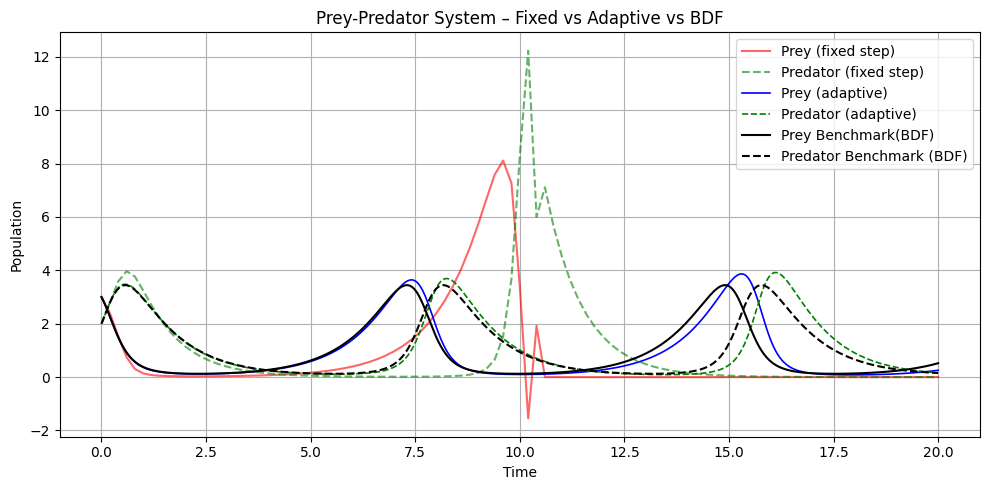

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Van der Pol ODE and Jacobian
def VanDerPol(t, x, mu):
    return [x[1], mu * (1 - x[0] ** 2) * x[1] - x[0]]

def VanDerPol_Jac(t, x, mu):
    return np.array([
        [0, 1],
        [-1 - 2 * mu * x[0] * x[1], mu * (1 - x[0] ** 2)]
    ])

# Prey-Predator ODE and Jacobian
def PreyPredator(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2
    return [dx1, dx2]

def PreyPredator_Jac(t, x, a, b):
    x1, x2 = x
    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)
    return [[dx1x1, dx1x2], [dx2x1, dx2x2]]

# Explicit Euler methods (fixed and adaptive)
def explicit_euler_fixed_step_size(fun, t0, tN, N, x0, *args):
    dt = (tN - t0) / N
    nx = len(x0)
    X = np.zeros((N + 1, nx))
    T = np.zeros(N + 1)
    T[0] = t0
    X[0, :] = x0
    for k in range(N):
        f = np.array(fun(T[k], X[k, :], *args))
        T[k + 1] = T[k] + dt
        X[k + 1, :] = X[k, :] + f * dt
    return T, X

def ExplicitEulerAdaptiveStep(fun, tspan, x0, h0, abstol, reltol, *args):
    epstol = 0.8
    facmin = 0.1
    facmax = 5.0
    t0, tf = tspan
    t = t0
    h = h0
    x = np.array(x0, dtype=float)
    T = np.array([t])
    X = np.array([x])
    while t < tf:
        if t + h > tf:
            h = tf - t
        f = np.array(fun(t, x, *args), dtype=float)
        AcceptStep = False
        while not AcceptStep:
            x1 = x + h * f
            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * f
            fm = np.array(fun(tm, xm, *args), dtype=float)
            x1hat = xm + hm * fm
            e = x1hat - x1
            denom = np.maximum(abstol, np.abs(x1hat) * reltol)
            r = np.max(np.abs(e) / denom)
            AcceptStep = r <= epstol
            if AcceptStep:
                t = t + h
                x = x1hat
                T = np.append(T, t)
                X = np.vstack([X, x.reshape(1, -1)])
            h = np.max([facmin, np.min([np.sqrt(epstol / r), facmax])]) * h
    return T, X

# Problem setup
tspan = (0, 20)
t_eval = np.linspace(tspan[0], tspan[1], 1000)

# --- Van der Pol ---
mu = 1000
x0_vdp = [2.0, 0.0]

sol_vdp_bdf = solve_ivp(
    VanDerPol, tspan, x0_vdp, args=(mu,), method='BDF',
    jac=VanDerPol_Jac, t_eval=t_eval, rtol=1e-9, atol=1e-12
)


# --- Prey-Predator ---
a, b = 1.0, 1.0
x0_pp = [3.0, 2.0]
N_pp = 100

T3, X3 = explicit_euler_fixed_step_size(PreyPredator, tspan[0], tspan[1], N_pp, x0_pp, a, b)
T4, X4 = ExplicitEulerAdaptiveStep(PreyPredator, tspan, x0_pp, 0.1, 1e-6, 1e-3, a, b)

sol_pp_bdf = solve_ivp(
    PreyPredator, tspan, x0_pp, args=(a, b), method='BDF',
    jac=PreyPredator_Jac, t_eval=t_eval, rtol=1e-9, atol=1e-12
)

# plt.figure(figsize=(10, 5))
# plt.plot(T3, X3[:, 0], 'r', label='Prey (fixed step)', alpha=0.6)
# plt.plot(T3, X3[:, 1],'--',label='Predator (fixed step)', alpha=0.6)
# plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2)
# plt.plot(T4, X4[:, 1], 'g--', label='Predator (adaptive)', linewidth=1.2)
# plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[0], 'k', label='Prey Benchmark(BDF)', linewidth=1.5)
# plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[1], 'k--', label='Predator Benchmark (BDF)', linewidth=1.5)
# plt.title("Prey-Predator System – Fixed vs Adaptive vs BDF")
# plt.xlabel("Time")
# plt.ylabel("Population")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()


plt.figure(figsize=(10, 5))
plt.plot(T3, X3[:, 0], label='Prey (fixed step)', alpha=0.6, color='red')
plt.plot(T3, X3[:, 1],'--',label='Predator (fixed step)', alpha=0.6, color='green')
plt.plot(T4, X4[:, 0], 'g', label='Prey (adaptive)', linewidth=1.2, color='blue')
plt.plot(T4, X4[:, 1], 'g--', label='Predator (adaptive)', linewidth=1.2)
plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[0], 'k', label='Prey Benchmark(BDF)', linewidth=1.5)
plt.plot(sol_pp_bdf.t, sol_pp_bdf.y[1], 'k--', label='Predator Benchmark (BDF)', linewidth=1.5)
plt.title("Prey-Predator System – Fixed vs Adaptive vs BDF")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


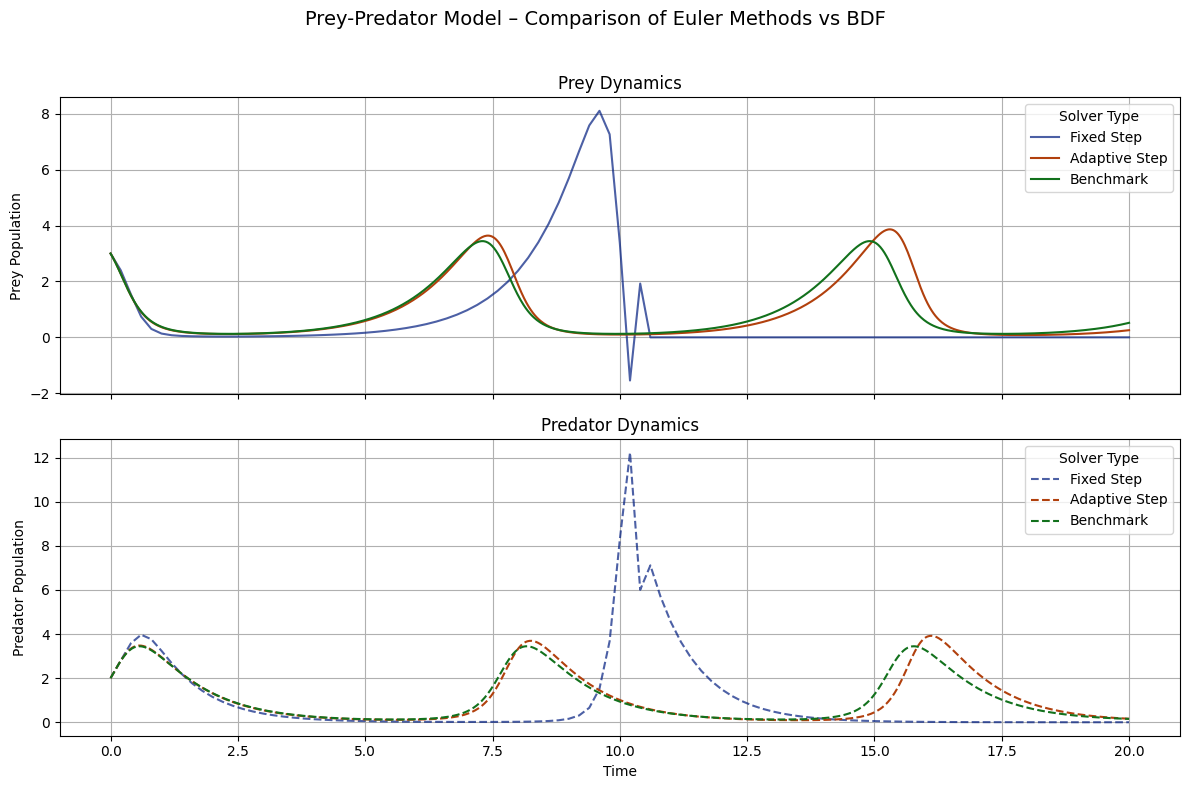

In [ ]:
import seaborn as sns

# Get the first 3 colorblind-friendly colors
colors = sns.color_palette("dark")
fixed_color = colors[0]     
adaptive_color = colors[1]  
bdf_color = colors[2]       


fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Prey subplot
axes[0].plot(T3, X3[:, 0], label='Fixed Step', color=fixed_color, alpha=0.7)
axes[0].plot(T4, X4[:, 0], label='Adaptive Step', color=adaptive_color, linestyle='-')
axes[0].plot(sol_pp_bdf.t, sol_pp_bdf.y[0], label='Benchmark', color=bdf_color, linestyle='-')
axes[0].set_ylabel("Prey Population")
axes[0].set_title("Prey Dynamics")
axes[0].legend(title="Solver Type")
axes[0].grid(True)

# Predator subplot
axes[1].plot(T3, X3[:, 1], label='Fixed Step', color=fixed_color, linestyle='--', alpha=0.7)
axes[1].plot(T4, X4[:, 1], label='Adaptive Step', color=adaptive_color, linestyle='--')
axes[1].plot(sol_pp_bdf.t, sol_pp_bdf.y[1], label='Benchmark', color=bdf_color, linestyle='--')
axes[1].set_ylabel("Predator Population")
axes[1].set_xlabel("Time")
axes[1].set_title("Predator Dynamics")
axes[1].legend(title="Solver Type")
axes[1].grid(True)

plt.suptitle("Prey-Predator Model – Comparison of Euler Methods vs BDF", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Bruger\AppData\Local\Temp\ipykernel_13852\2926170577.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Van der Pol Oscillator ($\mu=1000$) – Comparison to BDF")


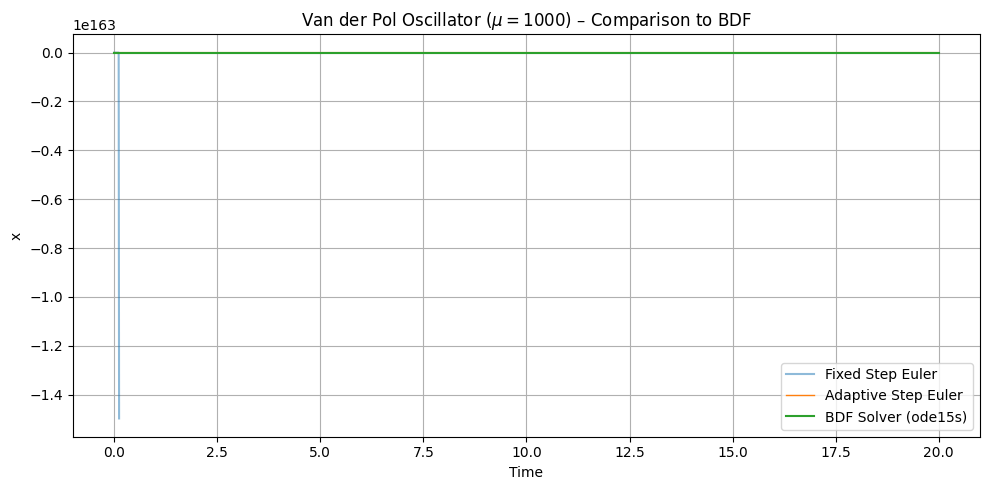

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(T1, X1[:, 0], label='Fixed Step Euler', alpha=0.5)
plt.plot(T2, X2[:, 0], label='Adaptive Step Euler', linewidth=1)
plt.plot(sol_ode15s.t, sol_ode15s.y[0], label='BDF Solver (ode15s)', linewidth=1.5)
plt.title("Van der Pol Oscillator ($\mu=1000$) – Comparison to BDF")
plt.xlabel("Time")
plt.ylabel("x")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
